In [1]:
import pandas as pd
from pandas import datetime
from sqlalchemy import create_engine 
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 1. 데이터불러오기

In [2]:
#CSV 파일 불러오기
customerData = pd.read_csv('KOPO_DECISION_TREE_ALL_NEW.csv')
# 컬럼해더 재정의
customerData.columns = customerData.columns.str.upper()
# 데이터 VIEW
customerData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.0
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.0
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.0
3,A01,PG01,P01,ITEM002,201526,2015,26,1,Y,1,N,0.0
4,A01,PG01,P01,ITEM002,201532,2015,32,1,N,4,N,0.0


### 2. 데이터 필터 및 정렬

In [3]:
# 컬럼삭제
del(customerData["HCLUS"])

In [4]:
# 오름차순정렬
customerData.sort_values(["REGIONID","PRODUCTGROUP","PRODUCT","ITEM","YEARWEEK"], ascending=True,inplace=True)
#인덱스 초기화
customerData.reset_index(drop=True,inplace=True)

In [5]:
#뉴메릭 타입으로 변환
a = {"HOLIDAY" : {"Y" : 1 , "N" : 0}}
customerData.replace(a,inplace =True)

In [6]:
datafullyearweek = 146
#그룹바이 필터  -- 146주가 다포함된 데이터만 추출
#그룹바이 끝날때마다 그룹이 되어 인덱스가 변하기때문에 reset_index를 항상해줘야함
customerData1=customerData.groupby(by = ["REGIONID","PRODUCTGROUP","PRODUCT","ITEM"]).filter(lambda x: x["YEARWEEK"].count()==datafullyearweek).reset_index(drop=True)

In [7]:
#53주차 제거
customerData1 = customerData1[customerData1["WEEK"] != 53].reset_index(drop =True)

In [8]:
# 상관계수 0.5 이상의 데이터 추출
customerData2=customerData1.groupby(by = ["REGIONID","PRODUCTGROUP","PRODUCT","ITEM"]).\
              filter(lambda x: x["QTY"].corr(x["PRO_PERCENT"]) >= 0.5 and x["QTY"].corr(x["HOLIDAY"]) >= 0.5).reset_index(drop=True)

### 3. 머신러닝 Arima 적용

In [9]:
planyearweek = 201700
def sub_function(data):
    #그룹바이 다음에 바로 apply(sub_function)이 들어갈거기때문에 맨첫줄에 reset_index 
    data.reset_index(inplace=True,drop=True)
    ########################################2017년기준으로 train ,test 데이터 분리##
    trainData = data[data["YEARWEEK"].astype(int)<planyearweek].reset_index(drop = True)
    testData = data[data["YEARWEEK"].astype(int)>=planyearweek].reset_index(drop = True)
    test = testData["QTY"].values
    train = trainData["QTY"].values
    history = [x for x in train]
    fcstARIMA = list()
    #################ARIMA 모델적용 ################
    for t in range(len(test)):
        model = ARIMA(history, order=(4,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        fcstARIMA.append(yhat)
        obs = test[t]
        history.append(obs)
    testData["PREDICT"] = fcstARIMA
    return testData

In [10]:
# arima는 feature값이 없으므로 예측 fit적용할때 예측할 갯수를 주지만 feature이있는 머신러닝 ex)decisiontree,linearRegression같은경우는
# 예측fit적용시 testData를 넣어준다.

In [11]:
newcustomerData = customerData1.groupby(["REGIONID","PRODUCTGROUP","PRODUCT","ITEM"]).apply(sub_function).reset_index(drop=True)

C:\Users\kopo\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
#예측값들이 list형태로되어있어 타입변환
newcustomerData["PREDICT"] = newcustomerData["PREDICT"].astype(float)

In [13]:
newcustomerData

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,PROMOTION,PRO_PERCENT,PREDICT
0,A01,PG02,P03,ITEM043,201701,2017,1,470,1,Y,0.240964,727.338587
1,A01,PG02,P03,ITEM043,201702,2017,2,293,0,Y,0.240964,386.363252
2,A01,PG02,P03,ITEM043,201703,2017,3,285,1,Y,0.201205,351.491261
3,A01,PG02,P03,ITEM043,201704,2017,4,304,0,Y,0.201205,286.519540
4,A01,PG02,P03,ITEM043,201705,2017,5,366,0,Y,0.320482,302.658041
...,...,...,...,...,...,...,...,...,...,...,...,...
2127,A01,PG05,P15,ITEM376,201737,2017,37,226,0,Y,0.271214,212.787674
2128,A01,PG05,P15,ITEM376,201738,2017,38,218,0,Y,0.271214,234.312806
2129,A01,PG05,P15,ITEM376,201739,2017,39,151,0,Y,0.245307,224.835843
2130,A01,PG05,P15,ITEM376,201740,2017,40,220,0,Y,0.245307,156.430390


### 4. 그룹바이 디버깅 시각화

In [14]:
groupNewcustomerData = newcustomerData.groupby(["REGIONID","PRODUCTGROUP","PRODUCT","ITEM"])

In [15]:
len(groupNewcustomerData)

52

In [16]:
#14개의 그룹중 첫번째 그룹을 가져옴
eachGroup = groupNewcustomerData.get_group(list(groupNewcustomerData.groups)[0])

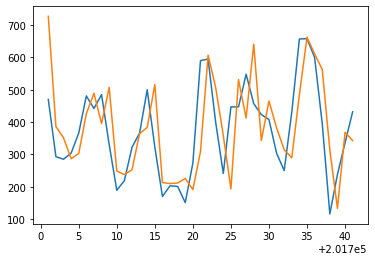

In [17]:
#실제값과 예측값 시각화 비교
plt.plot(eachGroup['YEARWEEK'],eachGroup['QTY'])
plt.plot(eachGroup['YEARWEEK'],eachGroup['PREDICT'])

### 5. 정확도 측정

In [18]:
mean_squared_error(newcustomerData['QTY'], newcustomerData['PREDICT'])


16306.625872012004

In [19]:
mean_absolute_error(newcustomerData['QTY'], newcustomerData['PREDICT'])

62.264991667932655

### 6. 데이터 CSV파일로 내보내기

In [20]:
#new_customerData.to_csv('arima.csv',index = False)